In [2]:
%matplotlib notebook
import aipy, uvtools
import numpy as np
import pylab as plt
import random
import math

In [3]:
from hera_sim import foregrounds, noise, sigchain, rfi

/anaconda3/lib/python3.6/site-packages/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/anaconda3/lib/python3.6/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/anaconda3/lib/python3.6/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/anaconda3/lib/python3.6/site-packages/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the wa

In [24]:
from jupyterthemes import jtplot
jtplot.style('grade3')

In [4]:
def get_k_rand_nums(start, stop, k):
    return sorted([random.uniform(start, stop) for x in range(k)])

def get_lsts(start, stop, num):
    print(start, stop)
    return np.linspace(start, stop, num, endpoint=False)

def plot_one_vis(vis, ylim):
    plt.figure()
    plt.subplot(211); uvtools.plot.waterfall(vis, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,ylim)
    plt.subplot(212); uvtools.plot.waterfall(vis, mode='phs'); plt.colorbar(); plt.ylim(0,ylim)
    plt.show()


# Generate two waterfall plots
`vis` and `vis_rfi`

In [5]:
# ORIGINAL
lsts = np.linspace(0,2*np.pi,4000, endpoint=False) # local sidereal times; start range, stop range, number of snapshots
# lsts = get_lsts(*get_k_rand_nums(0,2*np.pi,2), 1000) # lst has units of radians
fqs = np.linspace(.1,.2,1024,endpoint=False) # frequencies in GHz
# times = lsts / (2*np.pi) * aipy.const.sidereal_day 
bl_len_ns = np.array([30.,0,0]) # ENU coordinates

### Generate point source foreground

In [6]:
# foregrounds.pntsrc_foreground?

<IPython.core.display.Javascript object>


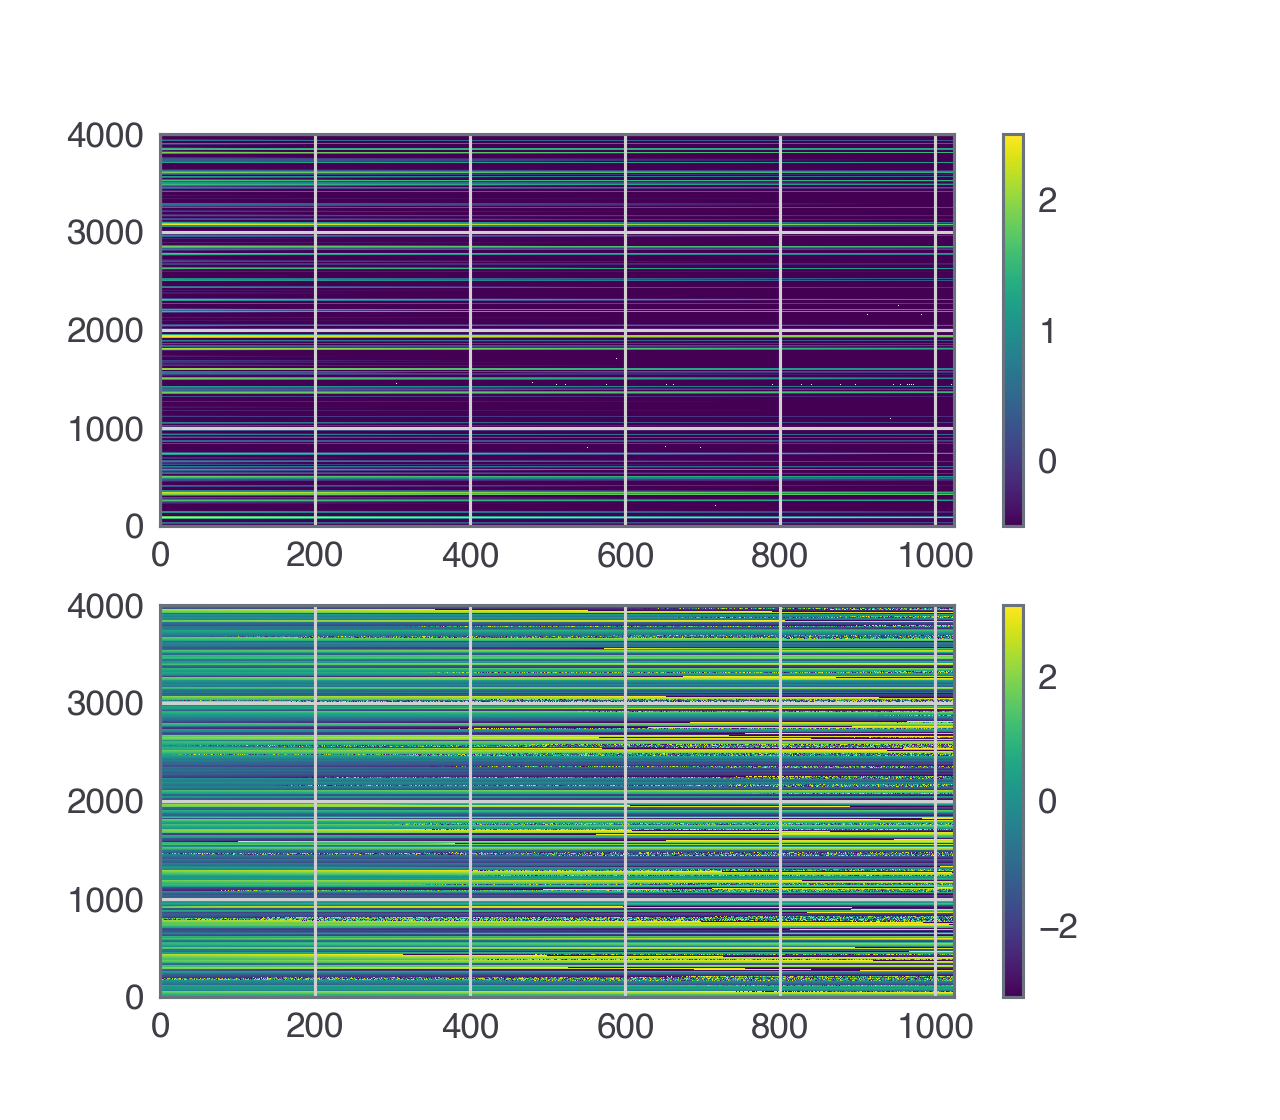

In [25]:
MX, DRNG = 2.5, 3
vis = foregrounds.pntsrc_foreground(lsts, fqs, bl_len_ns, nsrcs=200)

plot_one_vis(vis, 4000)

In [8]:
vis.shape

(4000, 1024)

### Generate diffuse source foreground

<IPython.core.display.Javascript object>


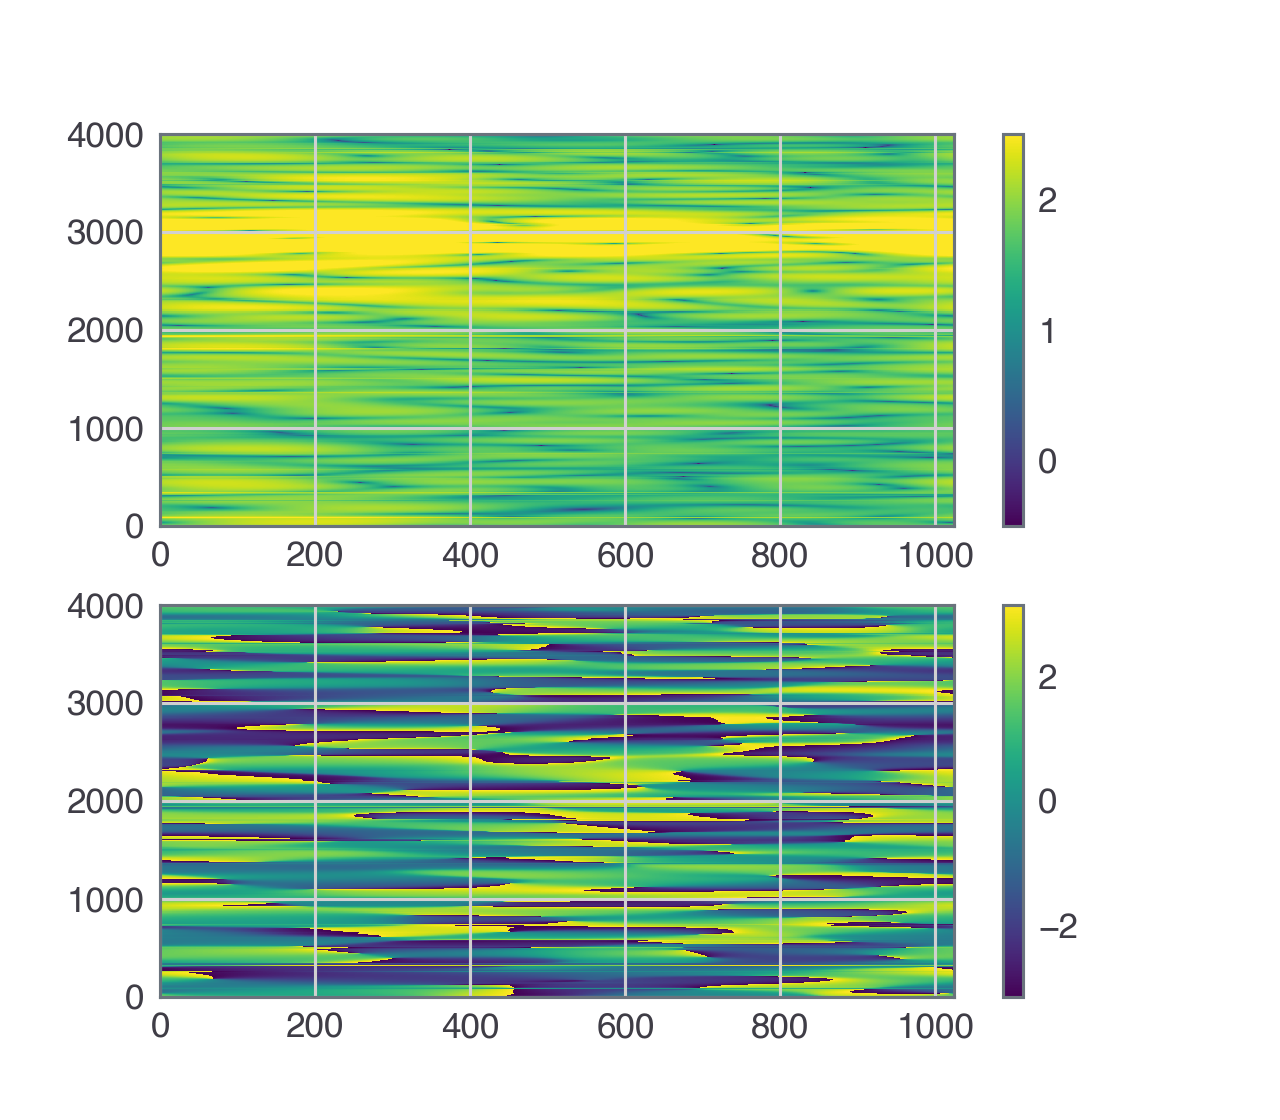

In [26]:
# bl_len_ns = np.array([30.])
Tsky_mdl = noise.HERA_Tsky_mdl['xx']
vis = vis + foregrounds.diffuse_foreground(lsts, fqs, bl_len_ns, Tsky_mdl) # add diffuse FG

MX, DRNG = 2.5, 3
plot_one_vis(vis, 4000)

### Generate RFI

In [10]:
# rfi.rfi_stations?

<IPython.core.display.Javascript object>


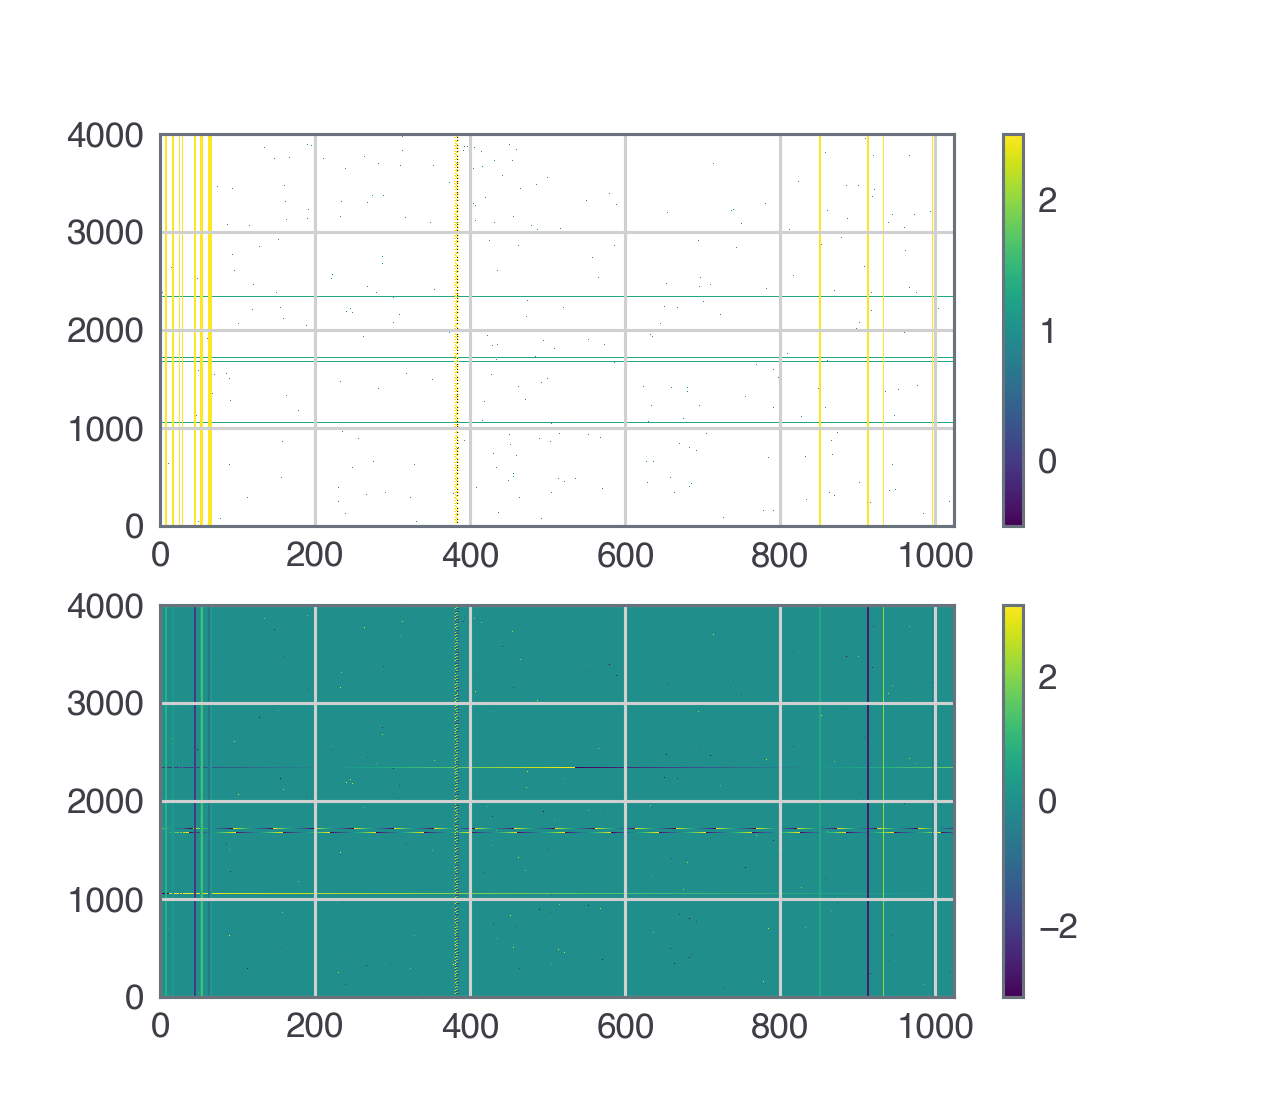

In [27]:
rfi1 = rfi.rfi_stations(fqs, lsts) # Default list of stations: rfi.HERA_RFI_STATIONS
rfi2 = rfi.rfi_impulse(fqs, lsts, chance=.02) # ORIGINAL: .02
rfi3 = rfi.rfi_scatter(fqs, lsts, chance=.001) # ORIGINAL: .001
rfi_all = rfi1 + rfi2 + rfi3

plot_one_vis(rfi_all, 4000)

### Shuffle RFI
Shuffle columns of RFI in order to get random RFI patterns

<IPython.core.display.Javascript object>


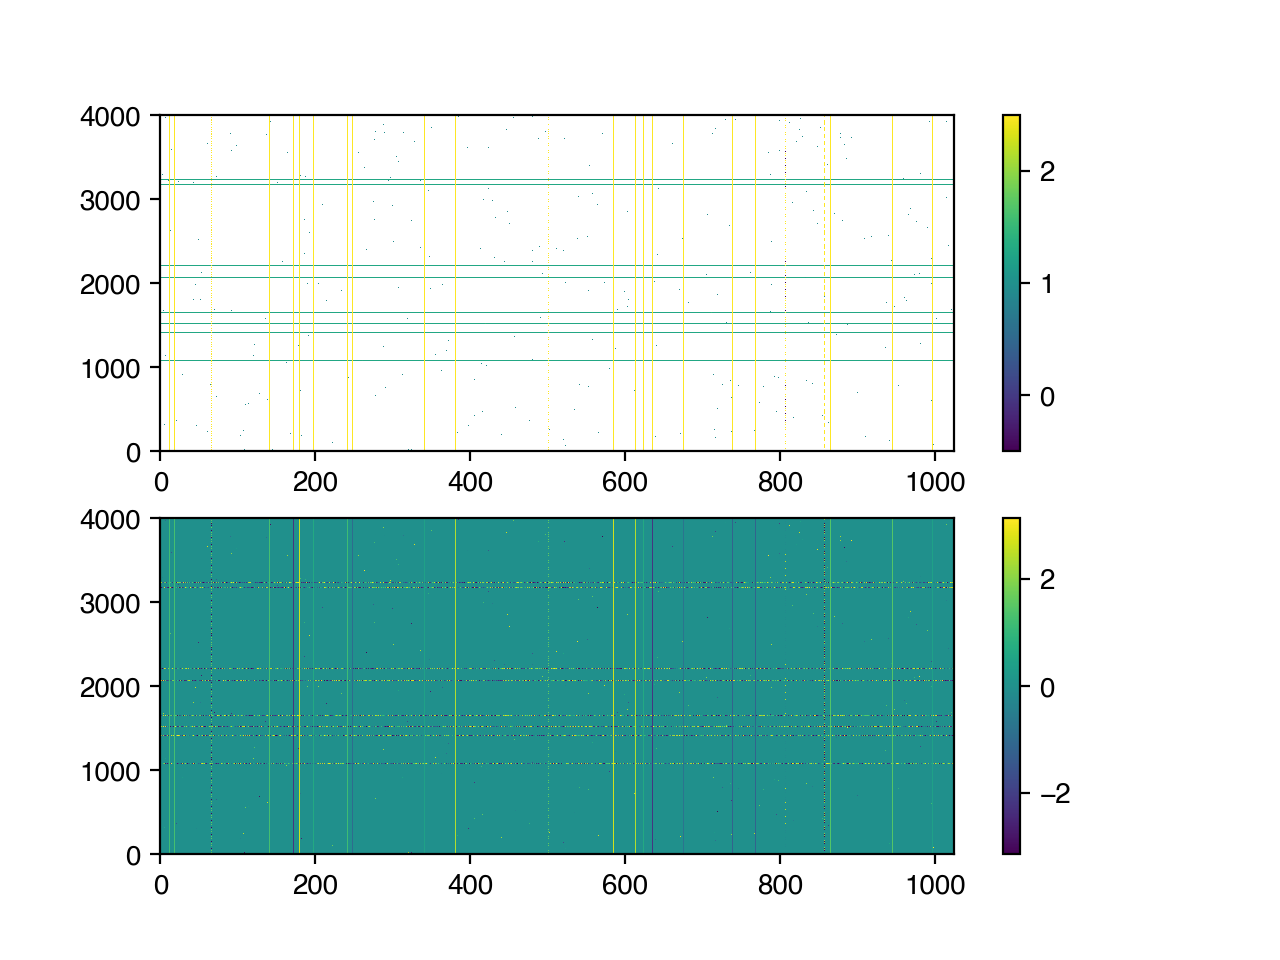

In [12]:
np.random.shuffle(rfi_all.T)
plot_one_vis(rfi_all, 4000)

vis_rfi = vis + rfi_all # add RFI to create a tainted map

### Generate noise
Should have variations!

In [13]:
# noise.sky_noise_jy?

<IPython.core.display.Javascript object>


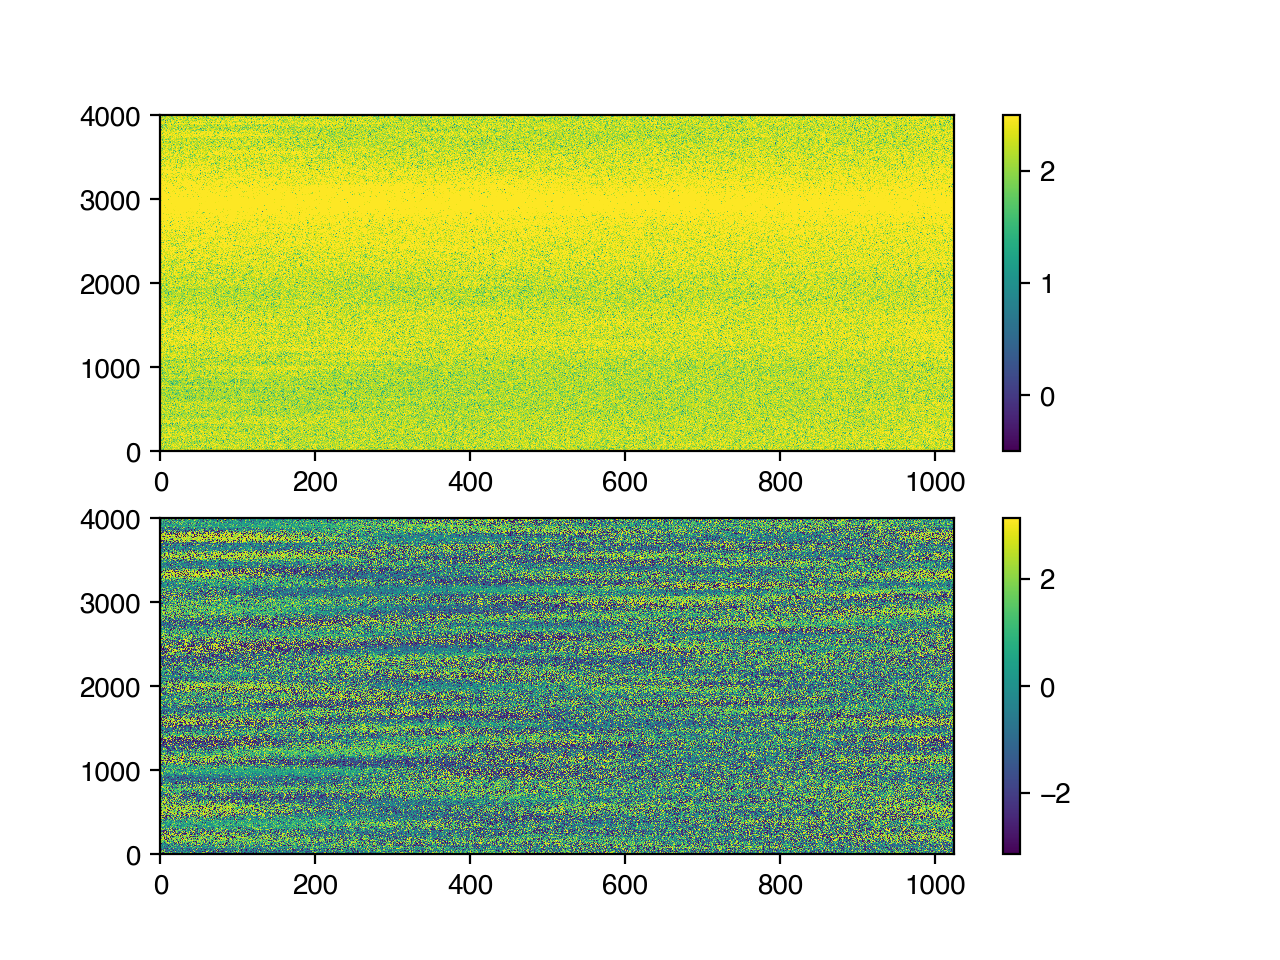

<IPython.core.display.Javascript object>


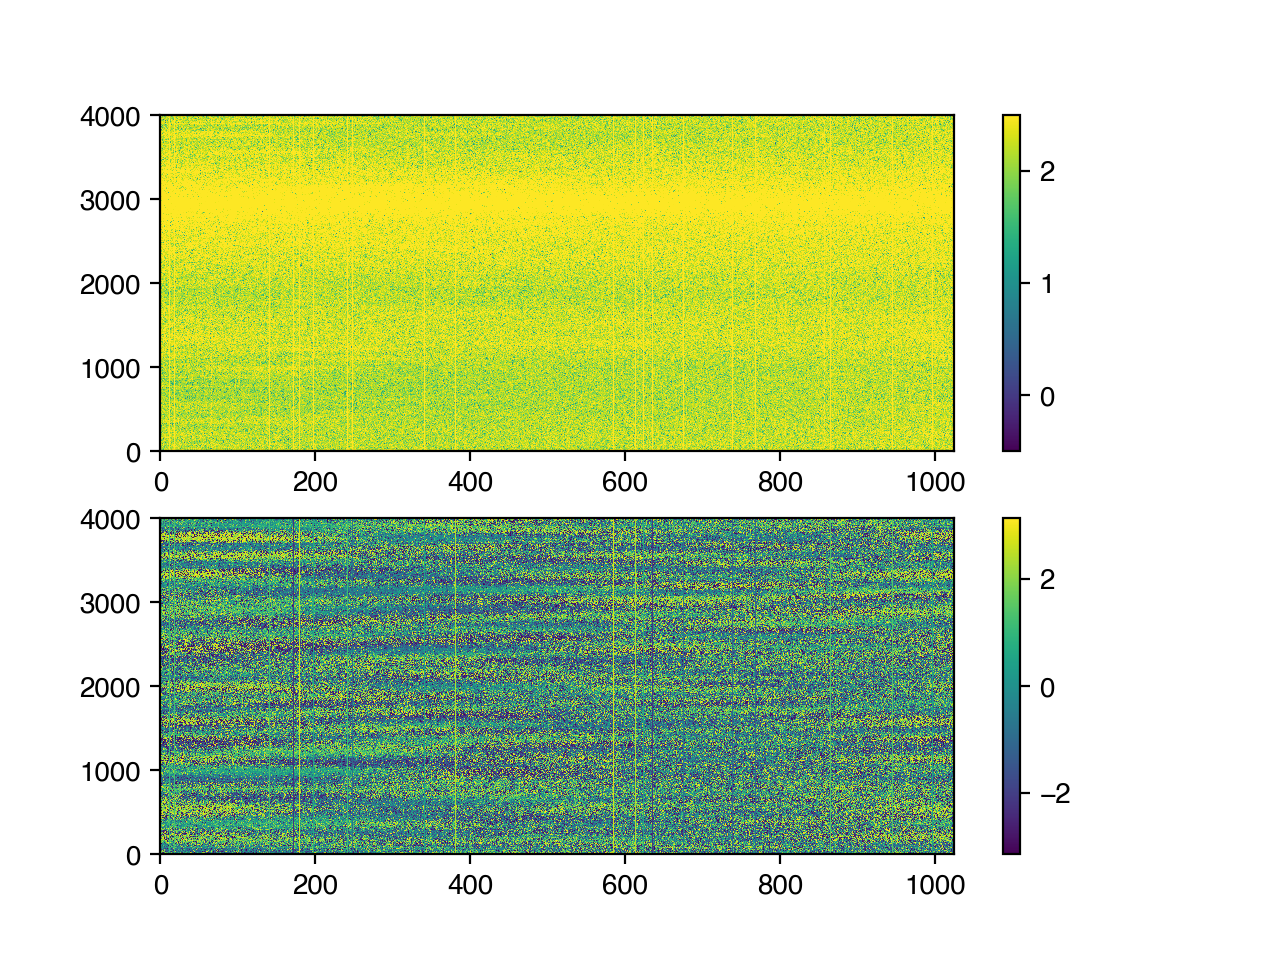

In [14]:
tsky = noise.resample_Tsky(fqs,lsts,Tsky_mdl=noise.HERA_Tsky_mdl['xx'])
t_rx = 150.
OMEGA_P = (0.72)*np.ones(1024) 
# .72 or smaller for omega_p; provided by Adrian, from literature

nos_jy = noise.sky_noise_jy(tsky + t_rx, fqs, lsts, OMEGA_P)

vis = vis + nos_jy
vis_rfi = vis_rfi + nos_jy

plot_one_vis(vis, 4000)
plot_one_vis(vis_rfi, 4000)

### Gain and Crosstalk

In [15]:
#####################
# TO BE ADDED
#####################

# Generate dataset
Split one waterfall plot into `l` sections

In [16]:
l = 100 # dataset length
m = l//2 # number of tainted samples

# CREATE DATASET
# np arrays ==> list of arrays
vis_dataset = np.split(vis,m)
vis_rfi_dataset = np.split(vis_rfi,m)
dataset = np.array(vis_dataset + vis_rfi_dataset) # includes all data

# CREATE LABELS
zeros = np.zeros(m, dtype=int)
ones = np.ones(m, dtype=int)
labels = np.array(np.concatenate((zeros, ones)))

# CHECK ONE PLOT
# plot_one_vis(vis_dataset[1], 400) # check a particular plot

<IPython.core.display.Javascript object>


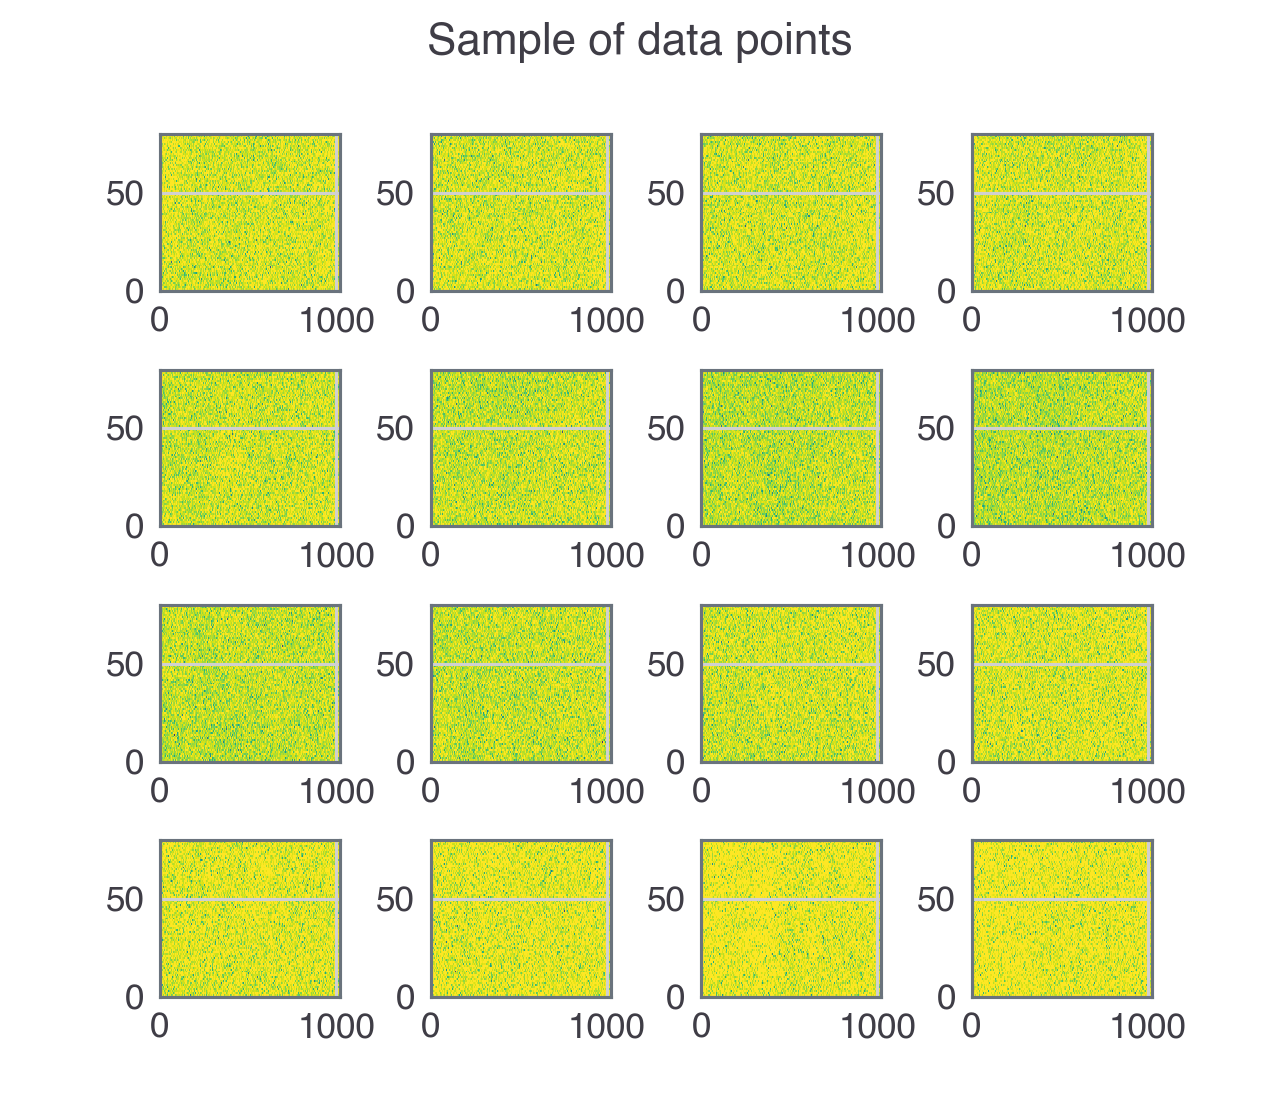

In [28]:
j = 4 # dimensions of subplots
l1 = 16 # number of plots to print

# SHOW LOG PLOTS
fig = plt.figure()
fig.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("Sample of data points")
for i in range(l1):
    plt.subplot(j, j, i+1); uvtools.plot.waterfall(dataset[l1+i], mode='log', mx=MX, drng=DRNG); plt.ylim(0,4000/m);
#     plt.xlabel("ok")
    
# SHOW PHS PLOTS
# fig = plt.figure()
# fig.subplots_adjust(hspace=0.6, wspace=0.6)
# for i in range(l1):
#     plt.subplot(j, j, i+1); uvtools.plot.waterfall(dataset[i], mode='phs', mx=MX, drng=DRNG); plt.ylim(0,400);

# Classification

In [18]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [19]:
# initialize test point
test_pt = vis_rfi_dataset[40]
test_pt = np.expand_dims(test_pt, axis=0) # add dimension of 1 at front
print(test_pt.shape)

(1, 80, 1024)


- ReLu activation function: for x, it returns max(0, x)
- He weight initialization is a good option: https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78

In [20]:
# configure the dataset
X, y = dataset, labels
X = X.astype('float32')

# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
############## how does it split???
############## see where it fails????
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
n_features = (X_train.shape[1], X_train.shape[2])
print(n_features)

# define model
model = tf.keras.Sequential()
model.add(layers.Flatten(input_shape=n_features))
model.add(layers.Dense(10, activation='relu', kernel_initializer='he_normal'))
model.add(layers.Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(layers.Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model
model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)

# evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

# make a prediction
yhat = model.predict([test_pt])
print('Predicted: %.3f' % yhat)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


(67, 80, 1024) (33, 80, 1024) (67,) (33,)
(80, 1024)
Test Accuracy: 0.818
Predicted: 1.000
